In [1]:
from utils_project import *
import plotly.graph_objs as go
import matplotlib.lines as mlines
from scipy.stats import pearsonr, ttest_1samp
import networkx as nx

def nanzscore(arr):
   arr_z = np.array([np.nan] * len(arr)) # create an array of nans the same size as arr
   mask = np.isfinite(arr) # mask the array
   arr_z[mask] = scipy.stats.zscore(arr[mask]) # calculate the zscore of the masked array
   return arr_z
   
def plot_3d_scatter(coords):
    # quick plot for embedding coords
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*coords.T, s=100, c='k')

def plot_trajectory(ax, xy, color='k'):
    ax.plot(*xy.T, color, alpha=0.25)
    ax.quiver(xy[0,0], xy[0,1],
                xy[-1,0]-xy[0,0], 
                xy[-1,1]-xy[0,1], 
                color=color, alpha=1, scale=1, scale_units='xy', width=0.02)  

def plot_predictions(ax, xy, state_pred_xy, beh_pred_xy, dots_xy=None, legend=False):
    # for state cluster + prediction
    xy_ = np.vstack([[0,0], xy])
    state_pred_xy_ = np.vstack([[0,0], state_pred_xy]) 
    beh_pred_xy_ = np.vstack([[0,0], beh_pred_xy])

    plot_trajectory(ax, xy_, color='k')
    plot_trajectory(ax, state_pred_xy_, color='r')
    plot_trajectory(ax, beh_pred_xy_, color='grey')

    ax.set_aspect('equal')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])

    real_traj = mlines.Line2D([], [], color='k', marker='.', linestyle='None', 
                              markersize=10, label='Real trajectory')
    state_pred = mlines.Line2D([], [], color='r', marker='.', linestyle='None', 
                               markersize=10, label='Predicted from states')
    beh_pred = mlines.Line2D([], [], color='grey', marker='.', linestyle='None', 
                             markersize=10, label='Predicted from behavior')
    handle_list = [real_traj, state_pred, beh_pred]
    
    if dots_xy is not None:
        ax.scatter(*dots_xy.T, color='b', s=50)
        dots_loc = mlines.Line2D([], [], color='b', marker='.', linestyle='None', markersize=10, label='Subjective location')
        handle_list.append(dots_loc)
        
    if legend: 
        ax.legend(handles=handle_list, bbox_to_anchor=(2.2, 1))

#--------------------------------------------------------------------------------------------------
# general helpers
#--------------------------------------------------------------------------------------------------

def get_sub_data(sub_id, data):
    return data[data['sub_id']==int(sub_id)]

def calc_cumulative_mean(values):
    # calculate the cumulative mean
    return np.cumsum(values, axis=0) / np.arange(1, len(values)+1)[:, None]

def one_hot_encode(labels, n_categories):
    # turn labels into a one-hot encoding
    onehot = np.zeros((labels.shape[0], n_categories))
    for i, c in enumerate(labels):
        onehot[i, c] = 1
    return onehot

#--------------------------------------------------------------------------------------------------
# co-clustering
#--------------------------------------------------------------------------------------------------

def sliding_window(timeseries, window_size, func):
    ''' slide over timeseries w/ a given window size and compute function '''
    windowed_data = [func(timeseries[i : i + window_size]) for i in range(len(timeseries) - window_size)]
    assert len(windowed_data) == len(timeseries) - window_size # correct number of windows
    return np.array(windowed_data)

def calc_shannon_entropy(data):
    """ Calculate the Shannon entropy of a dataset """
    probabilities = [np.sum(data==s)/len(data) for s in np.unique(data)] # probability of each unique state
    return scipy.stats.entropy(probabilities)

def number_unique_states(states):
    """ Calculate the number of unique states in a dataset """
    return len(np.unique(states))

#--------------------------------------------------------------------------------------------------
# transition matrices
#--------------------------------------------------------------------------------------------------

def find_center_node(pos):
    # find nearest node to center
    dmin, ncenter = 1, 0
    for n in pos:
        x, y = pos[n]
        d = (x - 0.5)**2 + (y - 0.5)**2
        if d < dmin:
            dmin, ncenter = d, n
    return ncenter, dmin

def plot_directed_graph(transition_matrix, prob_thresh=0):
    n_states = transition_matrix.shape[0]
    state_labels = [str(s+1) for s in range(n_states)]

    # plot directed graph
    fig, ax = plt.subplots(figsize=(5,5))
    dG = nx.DiGraph()
    dG.add_nodes_from(state_labels) # add nodes
    for i, j in itertools.product(range(n_states), range(n_states)): # add edges
        prob = transition_matrix[i, j]
        if prob > prob_thresh:
            dG.add_edge(state_labels[i], state_labels[j], weight=prob, label="{:.02f}".format(prob))

    pos = nx.spring_layout(dG) # node positions
    ncenter, dmin = find_center_node(pos) 
    path_lengths = dict(nx.single_source_shortest_path_length(dG, ncenter)) # color by path length from node near center
    labels = nx.get_edge_attributes(dG, 'weight')

    nx.draw_networkx_nodes(dG, pos, node_size=300, 
                        nodelist=list(path_lengths.keys()), node_color=list(path_lengths.values()),
                        cmap=plt.cm.magma_r, ax=axs[0])
    nx.draw_networkx_edges(dG, pos, nodelist=[ncenter], alpha=0.4, ax=axs[0])
    plt.show()

def plot_state_matrix(matrix, ax=None, 
                      cmap='magma', 
                      cbar=True,
                      cbar_label='Probability'):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    hm = ax.imshow(matrix, cmap=cmap)
    ax.set_xticks(np.arange(len(matrix)), np.arange(len(matrix)))
    ax.set_yticks(np.arange(len(matrix)), np.arange(len(matrix)))
    ax.set_aspect('equal')
    if cbar:
        add_colorbar(hm)
        cbar = hm.colorbar
        cbar.set_label(cbar_label, rotation=90, labelpad=10)
    ax.set_xlabel('Next state', fontsize=label_fontsize)
    ax.set_ylabel('Current state', fontsize=label_fontsize)

def calc_transition_matrix(states, n_states=None, step_size=1):

    '''assumes states is an ordered sequence'''

    # get unique states, jic not 0-indexed or not all states are present
    unique_states = np.unique(states) if n_states is None else np.arange(n_states)

    # count transitions for given step size
    tm = np.zeros((len(unique_states), len(unique_states)))
    for i in range(len(states) - step_size):
        curr_ = np.where(unique_states == states[i])[0][0]
        next_ = np.where(unique_states == states[i+step_size])[0][0]
        tm[curr_, next_] += 1
    tm = tm / tm.sum(axis=1, keepdims=True) # normalize the rows to sum to 1
    tm[np.isnan(tm)] = 0 # if no transitions for paricular state, will give nans
    return tm

def test_calc_transition_matrix():
    # Test case 1: 1D series with default step size
    states = np.array([1, 2, 3, 1, 2, 3, 3, 2, 1])
    transition_mat = calc_transition_matrix(states)
    expected_transition_mat = np.array([[0., 1, 0],
                                        [1/3, 0., 2/3],
                                        [1/3, 1/3, 1/3]])
    assert np.allclose(transition_mat, expected_transition_mat),\
            f'Expected: {expected_transition_mat}, got: {transition_mat}'
    
    # # Test case 2: 1D series with step size = 2
    # states = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    # transition_mat = calc_transition_matrix(states, step_size=2)
    # expected_transition_mat = np.array([[0., 0., 0., 0., 1.],
    #                                     [0., 0., 0., 1., 0.],
    #                                     [0., 0., 0., 0.5, 0.5],
    #                                     [0., 0., 0., 0., 1.],
    #                                     [0., 0., 0., 0., 0.],
    #                                     [0., 0., 0., 0., 0.],
    #                                     [0., 0., 0., 0., 0.],
    #                                     [0., 0., 0., 0., 0.],
    #                                     [0., 0., 0., 0., 0.],
    #                                     [0., 0., 0., 0., 0.]])
    # assert np.allclose(transition_mat, expected_transition_mat),\
    #         f'Expected: {expected_transition_mat}, got: {transition_mat}'
    
    # # Test case 3: 1D series with step size = 3
    # states = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    # transition_mat = calc_transition_matrix(states, step_size=3)
    # expected_transition_mat = np.array([[0., 0., 1.],
    #                                     [0., 0., 0.],
    #                                     [0., 0.5, 0.5],
    #                                     [0., 0., 1.],
    #                                     [0., 0., 0.],
    #                                     [0., 0., 0.],
    #                                     [0., 0., 0.],
    #                                     [0., 0., 0.],
    #                                     [0., 0., 0.],
    #                                     [0., 0., 0.]])
    # assert np.allclose(transition_mat, expected_transition_mat),\
    #         f'Expected: {expected_transition_mat}, got: {transition_mat}'
    
    # # Test case 4: 1D series with step size larger than series length
    # states = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    # transition_mat = calc_transition_matrix(states, step_size=20)
    # expected_transition_mat = np.zeros((10, 10))
    # assert np.allclose(transition_mat, expected_transition_mat),\
    #         f'Expected: {expected_transition_mat}, got: {transition_mat}'

test_calc_transition_matrix()

def calc_successor_representation(T, gamma=0.9):
    """
    Calculates the successor representation for a given transition matrix T and gamma level.
    
    Args:
    - T (numpy.ndarray): The transition matrix of the environment.
    - gamma (float): The discount factor where , default = 0.9
    
    Returns:
    - s (numpy.ndarray): The successor representation matrix.
    """
    
    # Get the number of states in the environment
    num_states = T.shape[0]
    
    # Initialize the  successor representation matrix
    sr = np.zeros((num_states, num_states))
    
    # Calculate the simple successor representation for each state
    for i in range(num_states):
        for j in range(num_states):
            sr[i, j] = T[i, j] + gamma * np.sum(sr[j, :] * T[i, :])
    
    return sr

def make_state_vector(state, n_states):
    # dummy coded state vector
    state_vec = np.zeros(n_states)
    state_vec[state] = 1
    return state_vec

def predict_states_from_transition_matrix(current_state_ix, transition_matrix, n_steps=5):

    """
    Predicts the sequence of next states by multiplying a current state vector
    by the transition matrix for a specified number of steps
    
    Args:
        current_state_ix (int): the integer index of the initial state
        transition_matrix (numpy.ndarray): the transition matrix as a numpy array
        num_steps (int): the number of steps to iterate
        
    Returns:
        numpy.ndarray: The sequence of states as a 2D numpy array, where each row
        represents a state vector
        also outputs states as indices and probabilities
    """

    # if current_state_ix is an array or list, re-assign as the index that == 1
    if isinstance(current_state_ix, (list, np.ndarray)):
        current_state_ix = np.where(current_state_ix == 1)[0][0]

    # check if current state is within range of transition matrix
    if current_state_ix >= transition_matrix.shape[0]:
        raise ValueError('Current state is out of state range')

    # create current state vector from integer
    current_state = np.zeros(len(transition_matrix))
    current_state[current_state_ix] = 1

    # initialize array of states with initial state
    states = [current_state]
    state_indices = [current_state_ix]
    state_probs = [] # wont include current state
    
    for _ in range(n_steps):

        # predict state by multiplying current state vector by transition matrix
        # new_state = np.dot(current_state, transition_matrix)
        new_state = transition_matrix @ current_state

        # set current state to the predicted state with maximum probability
        current_state = np.zeros_like(current_state)
        current_state[np.argmax(new_state)] = 1

        states.append(current_state)
        state_indices.append(np.argmax(current_state))
        state_probs.append(np.max(new_state))
        
    # returns w/ the initial state
    return np.vstack(states), np.array(state_indices), np.array(state_probs)

#--------------------------------------------------------------------------------------------------
# generic helper
#--------------------------------------------------------------------------------------------------

def convert_pvalue_to_onesided(pvalue: float, effect: float, alternative: str):
    if alternative in {'greater', 'less'}:
        return (
            pvalue / 2
            if (effect > 0 and alternative == 'greater')
            or (effect < 0 and alternative == 'less')
            else 1 - (pvalue / 2)
        )
    else:
        raise ValueError('alternative must be either "greater" or "less"')

Detected user: /Users/matty_gee
Base directory: /Users/matty_gee/Desktop/projects/trajectory
Included n=50
Found 39 mask nifties


# Run analysis locally

In [3]:
%%time
import random

emb_fnames, missing = get_fnames('*lle*.pkl', glm='lsa_decision_128hpf', ftype='embeddings')
for i, emb_fname in enumerate(emb_fnames):
    print(f'Processing {i+1}/{len(emb_fnames)}', end='\r')
    run_state_cluster_analysis(emb_fname, rois=['L_HPC_thr25'], n_clusters=15, verbose=False)

Found 50 embeddings files


100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


100%|██████████| 47/47 [00:07<00:00,  5.90it/s]


100%|██████████| 47/47 [00:07<00:00,  6.11it/s]


100%|██████████| 47/47 [00:07<00:00,  6.25it/s]


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


100%|██████████| 47/47 [00:07<00:00,  6.10it/s]


100%|██████████| 47/47 [00:07<00:00,  6.27it/s]


100%|██████████| 47/47 [00:07<00:00,  6.10it/s]


100%|██████████| 47/47 [00:07<00:00,  6.28it/s]


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


100%|██████████| 47/47 [00:07<00:00,  6.29it/s]


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


100%|██████████| 47/47 [00:07<00:00,  6.15it/s]


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


100%|██████████| 47/47 [00:07<00:00,  6.26it/s]


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


100%|██████████| 47/47 [00:07<00:00,  6.30it/s]


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


100%|██████████| 47/47 [00:07<00:00,  6.15it/s]


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


100%|██████████| 47/47 [00:07<00:00,  6.12it/s]


100%|██████████| 47/47 [00:07<00:00,  6.11it/s]


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


100%|██████████| 47/47 [00:07<00:00,  6.09it/s]


100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


100%|██████████| 47/47 [00:07<00:00,  6.09it/s]


100%|██████████| 47/47 [00:07<00:00,  6.14it/s]


100%|██████████| 47/47 [00:07<00:00,  6.22it/s]


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


100%|██████████| 47/47 [00:07<00:00,  6.36it/s]


100%|██████████| 47/47 [00:07<00:00,  6.26it/s]


100%|██████████| 47/47 [00:07<00:00,  6.13it/s]


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


100%|██████████| 47/47 [00:07<00:00,  6.10it/s]


100%|██████████| 47/47 [00:07<00:00,  6.16it/s]


100%|██████████| 47/47 [00:07<00:00,  6.19it/s]


100%|██████████| 47/47 [00:07<00:00,  6.24it/s]


100%|██████████| 47/47 [00:07<00:00,  6.21it/s]


100%|██████████| 47/47 [00:07<00:00,  6.07it/s]

CPU times: user 21h 12min 19s, sys: 16h 57min 36s, total: 1d 14h 9min 56s
Wall time: 3h 14min 50s


# Organize results

In [2]:
fname = 'cluster_results.xlsx'
overwrite = False
if (os.path.exists(fname)) & (not overwrite):
    results_df = pd.read_excel(fname)
else:

    cluster_fnames, missing = get_fnames('*lle*15ul*', ftype='state_clusters')
    plot_preds = False

    dims = ['5d', '6d', '7d']
    nns  = ['10nn', '20nn']
    rois = ['L_HPC_thr25']

    results_df = pd.DataFrame(columns=['sub_id', 'roi', 'dim', 'nn', 'n_train_states', 'n_test_states'] + 
                                    [f'n_states_{role}' for role in character_roles[:5]] +
                                    ['cluster_dist_diff', 'perm_dist_diff'] +
                                    [f'eucl_dist_char_{role}' for role in character_roles[:5]] +
                                    [f'null_dist_char_{role}' for role in character_roles[:5]] +
                                    ['eucl_dist', 'null_eucl_dist', 'cos_dist', 'null_cos_dist', 'eucl_dist_diff', 'cos_dist_diff'])
    errors = []
    for i, cluster_fname in enumerate(cluster_fnames):

        print(f'Processing {i+1}/{len(cluster_fnames)}', end='\r')
        sub_id = cluster_fname.split('/')[-1].split('_')[0]
        cluster_dict = pd.read_pickle(cluster_fname)
        behav = load_behavior(sub_id)[['char_decision_num', 'affil_coord', 'power_coord']]

        for roi, dim, nn in itertools.product(rois, dims, nns):

            if plot_preds: fig, axs = plt.subplots(1, 5, figsize=(10, 2))
            eucl, cos, null_eucl, null_cos, beh_eucl, beh_cos, eucl_diff, cos_diff = [], [], [], [], [], [], [], []
            n_train_states, n_test_states = [], []
            cluster_dist_diffs, perm_dist_diffs = [], []

            try:

                for i, (train_ix, test_ix) in enumerate(character_cv()):
                    
                    # unpack data
                    char_dict = cluster_dict[roi][dim][nn][f'char_0{i+1}']
                    n_train_states.append(len(np.unique(char_dict['train_states'])))
                    n_test_states.append(len(np.unique(char_dict['test_states'])))
                    
                    train_states, test_states = char_dict['train_states'], char_dict['test_states']
                    train_behav, test_behav = behav.iloc[train_ix,:], behav.iloc[test_ix,:]
                    train_xy = char_dict['train_states_xy']

                    # get predictions
                    xy      = char_dict['predictions'][['test_x', 'test_y']].values
                    pred_xy = char_dict['predictions'][['pred_x', 'pred_y']].values
                    perm_xy = char_dict['predictions'][['perm_x', 'perm_y']].values # circle shifted 
                    if np.any(np.isnan(perm_xy)): 
                        print(f'NaNs in {sub_id} {roi} {dim} {nn} {i+1}')

                    # error distances
                    pred_eucl_ = pairwise_distances(xy, pred_xy, metric='euclidean').diagonal()
                    pred_cos_  = pairwise_distances(xy, pred_xy, metric='cosine').diagonal()
                    null_eucl_ = pairwise_distances(xy, perm_xy, metric='euclidean').diagonal()
                    null_cos_  = pairwise_distances(xy, perm_xy, metric='cosine').diagonal()

                    # # error distances for a null behavioral model
                    # beh_pred_xy = np.mean(train_behav[train_behav['char_decision_num'] == 12][['affil_coord', 'power_coord']] / 6, axis=0).values
                    # beh_pred_xy = np.repeat(beh_pred_xy[np.newaxis,:], 12, axis=0)
                    # beh_eucl_   = pairwise_distances(xy, beh_pred_xy, metric='euclidean').diagonal()
                    # beh_cos_    = pairwise_distances(xy, beh_pred_xy, metric='cosine').diagonal()

                    if plot_preds: plot_predictions(axs[i], xy, pred_xy, perm_xy, dots_xy=None, legend=False)

                    eucl.append(pred_eucl_[-1])
                    cos.append(pred_cos_[-1])
                    null_eucl.append(null_eucl_[-1])
                    null_cos.append(null_cos_[-1])
                    eucl_diff.append(np.mean(null_eucl_ - pred_eucl_))
                    cos_diff.append(np.mean(null_cos_ - pred_cos_))
                    # beh_eucl.append(beh_eucl_[-1])
                    # beh_cos.append(beh_cos_[-1])

                    # are the classified neural states closer to the average xy from their cluster than the other clusters?
                    for i, trial_xy in enumerate(xy):

                        train_xy_   = train_xy.values.copy() # average xy values of the training states
                        cluster_num = test_states[i] # cluster classification of test state
                        cluster_xy  = train_xy_[cluster_num, :] 

                        # (affil, power) distance to cluster
                        cluster_dist = np.linalg.norm(trial_xy - cluster_xy)

                        # get the average (affil, power) distance to the other clusters
                        other_clusters_xy = np.delete(train_xy_, cluster_num, axis=0)
                        other_clusters_dist = np.mean(np.linalg.norm(trial_xy - other_clusters_xy, axis=1))

                        # chance distance from permutations (circle shifted)
                        perm_cluster_dist = np.linalg.norm(trial_xy - char_dict['perm_states_xy'].values)

                        cluster_dist_diffs.append(other_clusters_dist - cluster_dist)
                        perm_dist_diffs.append(other_clusters_dist - perm_cluster_dist)

            except Exception as e:
                print(f'{sub_id}: {e}')
                errors.append(f'error with {sub_id} {roi}')
                eucl = [np.nan, np.nan, np.nan, np.nan, np.nan]
                null_eucl = [np.nan, np.nan, np.nan, np.nan, np.nan]
                n_test_states = [np.nan, np.nan, np.nan, np.nan, np.nan]
                n_train_states, cos, null_cos, beh_eucl, beh_cos, eucl_diff, cos_diff = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

            results_df.loc[len(results_df)] = [sub_id, roi, dim, nn, np.mean(n_train_states), np.mean(n_test_states)] + n_test_states + \
                                            [np.mean(cluster_dist_diffs), np.mean(perm_dist_diffs)] + eucl + null_eucl + \
                                            [np.mean(eucl), np.mean(null_eucl), np.mean(cos), np.mean(null_cos), np.mean(eucl_diff), np.mean(cos_diff)]
            
    results_df['sub_id'] = results_df['sub_id'].astype(int)
    results_df = results_df.merge(data, on=['sub_id'])
    results_df.to_excel(fname, index=False)

    #--------------------------------------------------------------------------------
    # sanity check plots
    #--------------------------------------------------------------------------------

    # fig, axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
    # roi_df = results_df[results_df['roi'] == 'L_HPC_thr25']
    # sns.histplot(roi_df['n_train_states'], ax=axs[0], bins=5)
    # sns.histplot(roi_df['n_test_states'], ax=axs[1], bins=5)
    # plt.tight_layout()
    # plt.show()

In [5]:
for var in ['n_train_states', 'n_test_states']:
    for sample in ['Initial', 'Validation']:
        for roi in rois: 
            n_states = results_df[(results_df['sample'] == sample) & (results_df['roi'] == roi)][var]
            mean_, std_ = np.mean(n_states), np.std(n_states)
            range_ = np.max(n_states) - np.min(n_states)
            print(f'{sample} {roi} {var}: M={mean_:.2f} | SD= {std_:.2f}')

Initial L_HPC_thr25 n_train_states: M=8.06 | SD= 1.97
Validation L_HPC_thr25 n_train_states: M=8.66 | SD= 2.21
Initial L_HPC_thr25 n_test_states: M=4.72 | SD= 0.86
Validation L_HPC_thr25 n_test_states: M=4.83 | SD= 0.90


## Distance to classified cluster < distance to other clusters
- the assignment of held-out trials to a cluster seems to work
- but non-specifically: M1 also shows the effect

In [3]:
dist_var = 'perm_dist_diff'
ols_dfs = []
for roi in np.unique(results_df['roi']):
    results_df_ = results_df.dropna(subset=[dist_var]) # drop any subject with nans
    roi_diffs   = results_df_[(results_df_['roi'] == roi) & (results_df_['dim'] == '6d') & (results_df_['nn'] == '10nn')][dist_var]
    for sample in [['Initial'], ['Validation']]:
        sample_mask = results_df_['sample'].isin(sample)
        ols_df = run_ols(roi_diffs[sample_mask], covariates=None)[0]
        ols_df = ols_df[['dof', 'beta', '95%_lb', '95%_ub', 't', 'p_right']]
        ols_df.insert(0, 'sample', sample)
        ols_df.insert(0, 'roi', roi)
        ols_dfs.append(ols_df)
print_df(pd.concat(ols_dfs))       

|    | roi         | sample     |   dof |     beta |   95%_lb |   95%_ub |        t |     p_right |
|---:|:------------|:-----------|------:|---------:|---------:|---------:|---------:|------------:|
|  0 | L_HPC_thr25 | Initial    |    17 | 0.393097 | 0.299351 | 0.486843 |  8.84692 | 4.51761e-08 |
|  0 | L_HPC_thr25 | Validation |    31 | 0.500481 | 0.415901 | 0.585062 | 12.0683  | 1.50309e-13 |


## All characters have similarly good cluster classification

In [27]:
# test all combos of the 5 characters
res = pd.DataFrame(columns=['sample', 'char1', 'char2', 't', 'p'])
char_combos = list(itertools.combinations(character_roles[:5], 2))
for cc in char_combos:
    for sample in ['Initial', 'Validation']:
        # do it separately for each sample....
        sample_results = results_df[(results_df['sample'] == sample) & (results_df['roi'] == 'L_HPC_thr25') & (results_df['dim'] == '6d') & (results_df['nn'] == '5nn')]
        char_diff = sample_results[f'eucl_dist_char_{cc[0]}'] - sample_results[f'eucl_dist_char_{cc[1]}']
        char_diff = char_diff[~np.isnan(char_diff)]
        t, p = scipy.stats.ttest_1samp(char_diff, popmean=0)
        res.loc[len(res),:] = [sample, cc[0], cc[1], t, np.min([p * 10, 1])]
res = res.sort_values(by='p')
print_df(res)

|    | sample     | char1     | char2     |   t |   p |
|---:|:-----------|:----------|:----------|----:|----:|
|  0 | Initial    | first     | second    | nan | nan |
|  1 | Validation | first     | second    | nan | nan |
|  2 | Initial    | first     | assistant | nan | nan |
|  3 | Validation | first     | assistant | nan | nan |
|  4 | Initial    | first     | powerful  | nan | nan |
|  5 | Validation | first     | powerful  | nan | nan |
|  6 | Initial    | first     | boss      | nan | nan |
|  7 | Validation | first     | boss      | nan | nan |
|  8 | Initial    | second    | assistant | nan | nan |
|  9 | Validation | second    | assistant | nan | nan |
| 10 | Initial    | second    | powerful  | nan | nan |
| 11 | Validation | second    | powerful  | nan | nan |
| 12 | Initial    | second    | boss      | nan | nan |
| 13 | Validation | second    | boss      | nan | nan |
| 14 | Initial    | assistant | powerful  | nan | nan |
| 15 | Validation | assistant | powerful  | nan 

# Number of clusters correlates w/ social network size

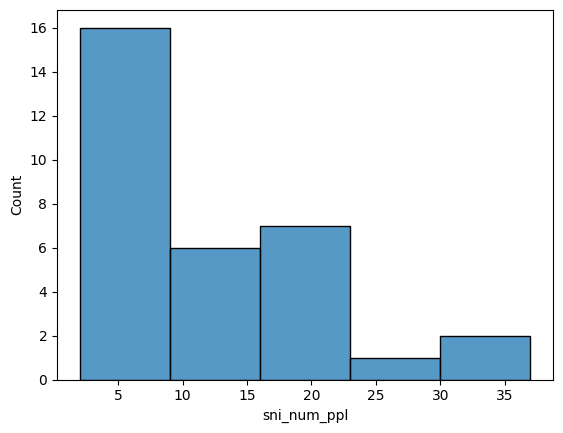

In [4]:
data_ = data[data['sample']=='Validation']

sns.histplot(data_, x='sni_num_ppl', bins=5, multiple='stack')
plt.show()

# are there any datapoints > 3 SD?
std = np.std(data_['sni_num_ppl'])
thresh = np.mean(data_['sni_num_ppl']) + 3*std
outliers = np.sum(data_['sni_num_ppl'] > thresh)

# zscore alternativve... same answer?
# np.sum(scipy.stats.zscore(data_['sni_num_ppl']) > 3)

,roi,sample,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right
1,L_HPC_thr25,Validation,Intercept + sni_num_ppl,n_test_states,sni_num_ppl,30.0,0.134,79.39,76.46,0.329967,0.137062,0.050049,0.609886,2.407424,0.022423,0.988788,0.011212
1,L_HPC_thr25,Validation,Intercept + sni_network_div,n_test_states,sni_network_div,30.0,0.046,82.49,79.56,0.227075,0.143863,-0.066733,0.520883,1.578409,0.124959,0.937520,0.062480


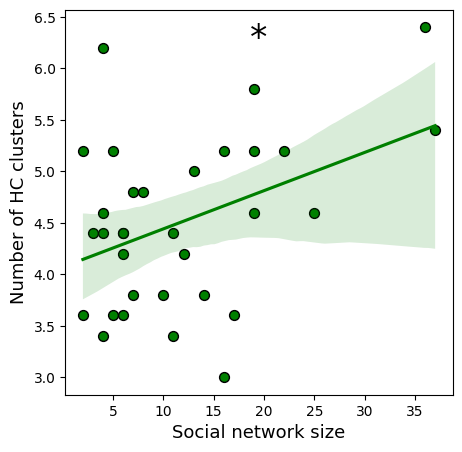

In [8]:
def get_stars(p):  
  if p < 0.01:
    return '**'
  elif p < 0.05:
    return '*'
  else:
    return ''

from scipy.stats import rankdata

#--------------------------------------------------------------------------------
# run GLM
#--------------------------------------------------------------------------------

dims = ['5d']
nns  = ['10nn']
social_vars = ['sni_num_ppl', 'sni_network_div']
cluster_vars = ['n_test_states']
covariates = None # ['reaction_time_mean', 'memory_mean_main']
for dim, nn  in itertools.product(dims, nns):

    ols_res, tau_res = [], []
    for roi, sv, cv in itertools.product(['L_HPC_thr25'], social_vars, cluster_vars):
        for sample in ['Validation']:
            results_df_ = results_df[(results_df['sample'].isin([sample])) 
                                    & (results_df['roi'] == roi) 
                                    & (results_df['dim'] == dim) 
                                    & (results_df['nn'] == nn)]
        
            # dealing with possible outliers...

            # exclude outliers
            # thresh = (np.mean(results_df_[sv]) + 2.5*np.std(results_df_[sv])).values[0]
            # incl = results_df_[sv].values < thresh
            # results_df_ = results_df_[incl]

            # rank regression
            # results_df_[f'{sv}_ranked'] = rankdata(results_df_[sv], method='average')
            # sv = f'{sv}_ranked'

            try: 

                # correlation
                tau, p = scipy.stats.kendalltau(results_df_[sv], results_df_[cv])
                tau_res.append([sv, roi, sample, dim, nn, tau, p])

                # regression
                ols_df = run_ols([sv], cv, data=results_df_, covariates=covariates)[0]
                ols_df.insert(0, 'sample', sample)
                ols_df.insert(0, 'roi', roi)
                ols_res.append(ols_df[ols_df['x'].isin([sv])])

            except:
                continue
        
    ols_res_df = pd.concat(ols_res)
    display(ols_res_df)
    
    tau_res_df = pd.DataFrame(tau_res, columns=['xvar', 'roi', 'sample', 'dim', 'nn', 'tau', 'p'])
    # display(tau_res_df)

    #--------------------------------------------------------------------------------
    # plot results
    #--------------------------------------------------------------------------------

    results_df_ = results_df[(results_df['sample'] == 'Validation') & 
                            (results_df['dim'] == dim) & 
                            (results_df['nn'] == nn)]
    color = sample_dict[sample]['color']

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
    #   fig.suptitle(f'{dim} {nn}', fontsize=20)

    p = ols_res_df[ols_res_df['x']=='sni_num_ppl']['p'].values[0]
    y, x = results_df_['n_test_states'], results_df_['sni_num_ppl']
    sns.regplot(x=x, y=y, ax=ax, color=color, scatter_kws={'alpha': 1, 's': 50, 'edgecolor': 'k', 'linewidth': 1})
    ax.set_ylabel('Number of HC clusters', fontsize=label_fontsize)
    ax.set_xlabel('Social network size', fontsize=label_fontsize)
    ax.annotate(get_stars(p), xy=(.5, .925), xycoords='axes fraction', fontsize=25, ha='center', va='center')

# #   ax = axs[1]
# #   p = ols_res_df[ols_res_df['x']=='sni_network_div']['p'].values[0]
# #   x = results_df_['sni_network_div']
# #   sns.regplot(x=x, y=y, ax=ax, color=color, scatter_kws={'alpha': 1, 's': 50, 'edgecolor': 'k', 'linewidth': 1})
# #   ax.set_ylabel('', fontsize=label_fontsize)
# #   ax.set_xlabel('Social network diversity', fontsize=label_fontsize)
# #   ax.annotate(get_stars(p), xy=(.5, .925), xycoords='axes fraction', fontsize=25, ha='center', va='center')

#     plt.show()

save_figure(fig, f'{fig_dir}/fig-5_cluster-number_network-size.png')

In [54]:
x, y, z = results_df_['sni_num_ppl'], results_df_['sni_network_div'], results_df_['n_test_states']
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color=z, colorscale='Viridis', opacity=0.8))])
fig.update_layout(scene=dict(xaxis_title='Number of people', yaxis_title='Network diversity', zaxis_title='Number of clusters'))
fig.show()

# Transition probabilities

maybe: convert the transition probabilities to distances, then ask: do these cluster distances track with the embedding distances and the behavioral social distances?
- what does this add? suggests the transitions between the clusters is a function of the manifold (not surprising) and social coordinates
- but I use the behavior to select the clusters... so would need to do this in a cross-validated way...

In [ ]:
from collections import defaultdict

def convert_transition_probs_to_dists(T):
    
    # adapted from Nieh et al 2021:
        # The random forest model provides us with a set of transition probabilities p(s(t + Δt)|s(t)) that 
        # can be translated into a local distance δ(s(t + Δt), s(t)) under a diffusion approximation, 
        # in which the transition probability p decreases with distance δ as p ∝ exp(−δ^2). 
        # Similar to isomap45, we then calculated the global distance between two states 
        # as the length of the shortest path from one to the other via any intermediate, 
        # connected states. The pairwise geodesic distances of l points ρ(i,j), in which 0 < i, j ≤ l, 
        # then yields a matrix of size l × l that was embedded using multidimensional scaling with 
        # Sammon’s nonlinear mapping. This yielded latent variables to describe population data. 
        # The mapping from latent space to neural activity and back was then achieved with LLE

    # convert to local distances
    local_distances = np.sqrt(-np.log(T+1e-10)) # using diffusion process approx.: transition probability ∝ exp(−distance^2)

    # calculate global geodesic distances using Dijkstra's algorithm
    graph = nx.DiGraph(local_distances) # weighted, directed graph from delta
    global_distances = dict(nx.all_pairs_dijkstra_path_length(graph))

    # sort & symmetrize
    distance_df = pd.DataFrame(global_distances).sort_index(axis=0).sort_index(axis=1)
    distance_df = distance_df + distance_df.T 
    return distance_df

def calculate_avg_dwell_time(sequence):

    state_dwell_times = defaultdict(int)
    state_counts = defaultdict(int)

    current_state = None
    current_dwell_time = 0

    # calculate dwell times
    for state in sequence:
        if state != current_state: # state transition has occurred
            if current_state is not None:
                state_dwell_times[current_state] += current_dwell_time
                state_counts[current_state] += 1
            current_state = state
            current_dwell_time = 1
        else: # increment the dwell time
            current_dwell_time += 1

    # Handle the last state in the sequence
    if current_state is not None:
        state_dwell_times[current_state] += current_dwell_time
        state_counts[current_state] += 1

    return {state: state_dwell_times[state] / state_counts[state] for state in state_dwell_times}


In [ ]:
emb_fnames, _ = get_fnames('lle', ftype='Embeddings')
res_df = pd.DataFrame(columns=['sub_id', 'avg_dwell_time', 'embedding_tau', 'behav_embedding_tau'])
for emb_fname in emb_fnames:

    #----------------------------------------------------------------------------------------------
    # get data
    #----------------------------------------------------------------------------------------------

    sub_id = emb_fname.split('/')[-1].split('_')[0]
    emb_dict = pd.read_pickle(emb_fname)
    embedding = emb_dict['L_HPC_thr25']['5d']['10nn']['embedding']
    
    #----------------------------------------------------------------------------------------------
    # maximize mutual information with the behavioral social locations
    # OR take the avg. number of clusters from the previous analysis...
    #----------------------------------------------------------------------------------------------

    cluster_clf = ClusterClassifier(n_clusters=5)
    cluster_clf.fit(embedding, behav.values[:, 1:])
    state_sequence = cluster_clf.labels_
    
    # transition probabilities --> distances --> MDS embedding
    transition_probs = calc_transition_matrix(state_sequence)
    cluster_dists = convert_transition_probs_to_dists(transition_probs).values # convert to distances
    mds_embedding = MDS(n_components=2, dissimilarity='precomputed').fit_transform(cluster_dists) # embed distances into 2D

    #----------------------------------------------------------------------------------------------
    # tryna come up with new measures of the manifold...
    #----------------------------------------------------------------------------------------------

    # average dwell time in each state
    dwell_times = calculate_avg_dwell_time(state_sequence)
    avg_dwell_time = np.mean(list(dwell_times.values()))

    #----------------------------------------------------------------------------------------------
    # compare distances
    #----------------------------------------------------------------------------------------------
    
    behav_xy = load_behavior(sub_id)[['char_decision_num', 'affil_coord', 'power_coord']]
    behav_xy.insert(3, 'cluster', state_sequence)
    behav_xy_avg = behav_xy.groupby('cluster').mean().reset_index()
    behav_dists = pairwise_distances(behav_xy_avg[['affil_coord', 'power_coord']].values)

    embedding = pd.DataFrame(embedding)
    embedding.insert(5, 'cluster', state_sequence)
    embedding_avg = embedding.groupby('cluster').mean().reset_index()
    embedding_dists = pairwise_distances(embedding_avg.values[:, :5])

    behav_rdv = symm_mat_to_ut_vec(behav_dists)
    embedding_rdv = symm_mat_to_ut_vec(embedding_dists)
    neural_rdv = symm_mat_to_ut_vec(cluster_dists)

    # behav_tau = kendalltau(neural_rdv, behav_rdv)[0]
    embedding_tau = kendalltau(neural_rdv, embedding_rdv)[0]
    behav_embedding_tau = kendalltau(behav_rdv, embedding_rdv)[0]

    res_df.loc[len(res_df)] = [int(sub_id), avg_dwell_time, embedding_tau, behav_embedding_tau]

    # #----------------------------------------------------------------------------------------------
    # # plot the state sequences
    # #----------------------------------------------------------------------------------------------

    # fig, ax = plt.subplots(1, 1, figsize=(30, 1))
    # sns.heatmap(state_sequence.reshape(1,-1), ax=ax)
    # ax.set_yticks([])
    # plt.show()

    # #----------------------------------------------------------------------------------------------
    # # plot transition matrix & distance matrix
    # #----------------------------------------------------------------------------------------------

    # fig, axs = plt.subplots(1, 3, figsize=(13, 4))
    # ax = axs[0]
    # plot_state_matrix(T, cbar_label='Probability', cmap='magma_r', ax=ax)
    # ax.set_title('Transition probabilities', fontsize=title_fontsize)
    # ax = axs[1]
    # plot_state_matrix(digitize_matrix(cluster_dists), cbar_label='Distance', ax=ax)
    # ax.set_title('Geodesic distances (digitized)', fontsize=title_fontsize)
    # ax = axs[2]
    # ax.set_title('Embedded states', fontsize=title_fontsize)
    # sns.scatterplot(x=mds_embedding[:,0], y=mds_embedding[:,1], s=100, 
    #                 color='grey', edgecolor='black', linewidth=1, ax=ax)
    # plt.tight_layout()

results_df_ = results_df[(results_df['roi'] == 'L_HPC_thr25') & (results_df['dim'] == '5d')]
res_df =  res_df.merge(results_df_, on='sub_id')
# sns.histplot(res_df['avg_dwell_time'])
# plt.show()

In [ ]:
res_df_  = res_df[res_df['roi'] == 'L_HPC_thr25']
corr_df_ = res_df_[['n_train_states', 'n_test_states', 'avg_dwell_time'] + 
                   ['sni_num_close_friends', 'sni_num_ppl', 'sni_network_div', 
                    'lsas_fear_score2', 'lsas_av_score2', 'lsas_total_score', 'ctq_score'] + 
                   ['volume', 'consistency_mean'] + ['dots_avg_pw_dist', 'dots_area']]
cm = corr_df_.corr()
cm = cm[np.abs(cm) > 0.33]
sns.heatmap(cm)
plt.show()

# DISCARD

# Trajectory prediction better than permutation null?
Permute the training labels before paramterizing clusters: maintain cluster assignment for test data, circle shift which behavior is in which so break relationship between behavioral parameterization & brain states

Better in euclidean distance, not better in cosine distance: so angle is ~same as permuting the data (general directional tendency) but the magnitude is lost

In [ ]:
perm_results_df = pd.DataFrame(columns=['sample', 'n', 'roi', 'metric', 't', 'p'])
for metric in ['eucl', 'cos']:
    for roi in np.unique(results_df['roi']):
        results_df_  = results_df.dropna(subset=[f'{metric}_dist', f'null_{metric}_dist']) # drop any subject with nans
        roi_errors   = results_df_[results_df_['roi'] == roi][f'{metric}_dist']
        null_errors  = results_df_[results_df_['roi'] == roi][f'null_{metric}_dist']
        diffs        = null_errors - roi_errors
        diffs        = results_df_[results_df_['roi'] == roi][f'{metric}_dist_diff']

        # t-tests: null errors - roi errors: expect positive values if roi is better than null
        for sample in ['Initial', 'Validation', 'Both']:
            if sample == 'Both':
                sample_mask = results_df_['sample'].isin(['Initial', 'Validation'])
            else:
                sample_mask = results_df_['sample'] == sample
            t, p = scipy.stats.ttest_1samp(diffs[sample_mask], popmean=0, alternative='greater')
            perm_results_df.loc[len(perm_results_df)] = [sample, len(diffs[sample_mask]), roi, metric, t, p]

print_df(perm_results_df)

### Better than other ROIs? Yes for Validation sample, no for Initial sample (strong M1 effect)

In [ ]:
ctl_rois = ['M1-p_thr25']
roi_results_df = pd.DataFrame(columns=['sample', 'n', 'roi', 'hemi', 'metric', 't', 'p'])
for ctl_roi in ctl_rois:
    for metric in ['eucl', 'cos']:
        for hemi in ['L']:
            
            ctl_roi_df = results_df[results_df['roi'] == f'{hemi}_{ctl_roi}']
            hpc_roi_df = results_df[results_df['roi'] == f'{hemi}_HPC_thr25']

            # find sub_ids in both and subset both for them
            ctl_sub_ids = set(ctl_roi_df['sub_id'].values)
            hpc_sub_ids = set(hpc_roi_df['sub_id'].values)
            common_sub_ids = ctl_sub_ids.intersection(hpc_sub_ids)
            ctl_roi_df = ctl_roi_df[ctl_roi_df['sub_id'].isin(common_sub_ids)]
            hpc_roi_df = hpc_roi_df[hpc_roi_df['sub_id'].isin(common_sub_ids)]
            diffs = ctl_roi_df[f'{metric}_dist'].values - hpc_roi_df[f'{metric}_dist'].values

            for sample in ['Initial', 'Validation']:
                sample_mask = ctl_roi_df['sample'] == sample
                t, p = scipy.stats.ttest_1samp(diffs[sample_mask], popmean=0, alternative='greater') # paired samples t-test
                roi_results_df.loc[len(roi_results_df)] = [sample, np.sum(sample_mask), ctl_roi, hemi, metric, t, p]
            
print_df(roi_results_df)

### Better than behavior only? No lol

In [ ]:
beh_results_df = pd.DataFrame(columns=['n', 'roi', 'metric', 't', 'p'])
for metric in ['cos', 'eucl']:
    for roi in np.unique(results_df['roi']):
        roi_values = results_df[results_df['roi'] == roi][f'{metric}_dist'].values
        beh_values = results_df[results_df['roi'] == roi][f'beh_{metric}_dist'].values
        diffs = beh_values - roi_values
        t, p = scipy.stats.ttest_1samp(diffs, popmean=0, alternative='greater')
        beh_results_df.loc[len(beh_results_df)] = [len(diffs), roi, metric, t, p]
        
print_df(beh_results_df)

# Behavioral trajectories

In [ ]:
beh_trajs = get_behav_trajectories()
beh_traj_rdvs = [symm_mat_to_ut_vec(pairwise_trajectory_distances(bt, metric='frechet')) for bt in beh_trajs] # frechet,  hausdorff, or dtw
beh_traj_dist = [np.mean(x) for x in beh_traj_rdvs] # average distance/dissimilarity between

data['beh_traj_dist'] = beh_traj_dist
results_df_ = results_df[results_df['roi'] == 'L_HPC_thr25']
results_df_ = results_df_.merge(data[['sub_id', 'beh_traj_dist']], on='sub_id', how='left')
print(f'n={len(results_df_)}')

# plot mean...
# rdm = ut_vec_to_symm_mat(np.mean(beh_traj_rdvs, 0))
# print(np.round(rdm, 3))
# plot_rdm(rdm, figsize=(4, 4))
# plt.show()

## Change over task

In [ ]:
# results_df = pd.DataFrame(columns=['sub_id', 'roi', 'dim', 'nn', 'n_states_train', 'n_states_test', 'n_states'] + 
#                                   ['n_states_half1', 'n_states_half2'] +
#                                   [f'n_states_{role}' for role in character_roles[:5]] +
#                                   [f'char_states_win{c}' for c in range(1, n_windows+1)])

# for sub_id in states.keys():
#     states_sub = states[sub_id]

#     # cross-validated number of states....
#     n_states_train = np.mean([len(np.unique(states_sub[c]['train'])) for c in range(1,6)])
#     n_states_test = np.mean([len(np.unique(states_sub[c]['test'])) for c in range(1,6)])

#     # overall number of states
#     states_sub = states_sub['all']

#     # number of unique states
#     states_  = remove_neutrals(states_sub)
#     n_states = len(np.unique(states_)) # overall number of states
#     n_states_h1, n_states_h2 = len(np.unique(states_[:30])), len(np.unique(states_[30:]))

#     # states by character
#     states_char   = organize_by_character(states_sub)    
#     n_states_char = [number_unique_states(states_char[c]) for c in range(5)] # unique states per character
#     n_states_sw   = [sliding_window(states_char[c], n_windows, number_unique_states) for c in range(5)] # unique states per character per window
#     n_states_sw   = np.mean(n_states_sw, axis=0) # window averages across characters

#     # # shannon entropy
#     # entropy      = calc_shannon_entropy(states_) # overall entropy
#     # entropy_char = [calc_shannon_entropy(states_char[c]) for c in range(5)] # entropy per character
#     # entropy_sw   = [sliding_window(states_char[c], n_windows, calc_shannon_entropy) for c in range(5)] # entropy per character per window
#     # entropy_sw   = np.mean(entropy_sw, axis=0) # window averages across characters

#     # output
#     results_df.loc[len(results_df), :] = [sub_id, roi, d, nn, n_states_train, n_states_test, 
#                                           n_states, n_states_h1, n_states_h2, 
#                                           *n_states_char, *n_states_sw]

# float_cols = [c for c in results_df.columns if ('states' in c) or ('entropy' in c)]
# results_df[float_cols] = results_df[float_cols].astype(float)
# results_df['sub_id']   = results_df['sub_id'].astype(int)

# results_df['n_states_half_diff']    = (results_df['n_states_half2'] - results_df['n_states_half1']) / results_df['n_states_half1']
# results_df['char_states_win_diff']  = (results_df[f'char_states_win{n_windows}'] - results_df['char_states_win1']) / results_df['char_states_win1']

# results_df = results_df.merge(data, on=['sub_id'])
# # print_df(results_df.head(4))